In [19]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import gdown
import zipfile
import json
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image 
import torchvision
import PIL
from sklearn.metrics import confusion_matrix, roc_curve, auc
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Download dataset

In [5]:
# gdown.download_folder("https://drive.google.com/drive/folders/19XjDFtOGimZjoRc42moVsJBclKBpoYDQ?usp=sharing")

Retrieving folder list


Processing file 1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI rgb-images.zip
Processing file 1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI road_waymo_trainval_v1.0.json
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From (uriginal): https://drive.google.com/uc?id=1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI
From (redirected): https://drive.google.com/uc?id=1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI&confirm=t&uuid=8550631a-af6f-439e-9012-754c6ff5208d
To: C:\Users\mtang\Desktop\VisionFinal\road-waymo\rgb-images.zip
100%|█████████████████████████████████████| 5.10G/5.10G [10:09<00:00, 8.37MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI
From (redirected): https://drive.google.com/uc?id=1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI&confirm=t&uuid=1e8f796d-0c0f-4318-b4a1-85028b2723de
To: C:\Users\mtang\Desktop\VisionFinal\road-waymo\road_waymo_trainval_v1.0.json
100%|█████████████████████████████████████| 1.05G/1.05G [02:19<00:00, 7.57MB/s]
Download completed


['C:\\Users\\mtang\\Desktop\\VisionFinal\\road-waymo\\rgb-images.zip',
 'C:\\Users\\mtang\\Desktop\\VisionFinal\\road-waymo\\road_waymo_trainval_v1.0.json']

In [9]:
# with zipfile.ZipFile("road-waymo/rgb-images.zip","r") as zip_ref:
#     zip_ref.extractall("road-waymo/rgb-images")

In [10]:
with open("road-waymo/road_waymo_trainval_v1.0.json","r") as fp:
    dat = json.load(fp)

In [12]:
# Write a sample to view
sample = dat['db']['train_00017']
with open("road-waymo/sample.json", "w") as fp:
    json.dump(sample,fp)

In [13]:
def has_ped(frame):
    if 'annos' not in frame:
        return False
    for id,anno in frame['annos'].items():
        if 7 in anno['agent_ids']:
            return True
    return False

In [14]:
has_ped(dat['db']['train_00017']['frames']['128'])

False

In [16]:
image_dir = "road-waymo/rgb-images/"
videos = os.listdir(image_dir)

In [17]:
filenames = []
classifications = []
for vid in videos:
    if vid.startswith("."):
        continue
    frames = dat['db'][vid]['frames']
    for frame in frames:
        ped = has_ped(frames[frame])
        filename = f'{vid}/{frame.zfill(5)}'
        
        # skip if image doesn't exist
        fullpath = os.path.join(image_dir, filename+".jpg")
        if not os.path.isfile(fullpath):
            continue 

        filenames.append(filename)
        classifications.append(ped)
        # if ped:
        #     print(f"{vid} {frame}")
labels = pd.DataFrame({"image":filenames, "label":classifications})
labels.to_csv("./processed_labels.csv", index=False)

# Load dataset

In [3]:
def select_equal_samples(data, label_column='label'):
    """ Select equal # of pos/neg samples """
    positive_samples = data[data[label_column] == True]
    negative_samples = data[data[label_column] == False]

    # Determine the number of samples to select (minimum of positive and negative samples)
    num_samples = min(len(positive_samples), len(negative_samples))

    # Randomly select equal number of positive and negative samples without replacement
    selected_positive_samples = positive_samples.sample(n=num_samples, random_state=42, replace=False)
    selected_negative_samples = negative_samples.sample(n=num_samples, random_state=42, replace=False)

    # Concatenate the selected samples
    selected_samples = pd.concat([selected_positive_samples, selected_negative_samples])

    return selected_samples

In [4]:
class PedestrianClassificationDataset(Dataset):

    def __init__(self, labels_csv, root_dir, balance_labels=True, transform=None):
        self.labels = pd.read_csv(labels_csv)
        if balance_labels:
            self.labels = select_equal_samples(self.labels)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {True: 1, False: 0}
        # self.image_files = sorted(self.labels['image'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_name = row['image'] + ".jpg"
        image_name = os.path.join(self.root_dir, image_name) 
        image = read_image(image_name) / 255
        label = self.class_to_idx[row['label']]
        if self.transform:
            image = self.transform(image)
        return (image, label)

Dataset len:  5174
0


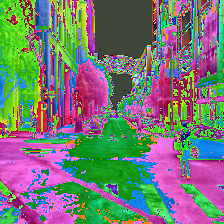

In [5]:
transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(224, 224), antialias=True),
            torchvision.transforms.Normalize(mean=0.485, std=0.225),])

dataset = PedestrianClassificationDataset("./processed_labels.csv","./road-waymo/rgb-images/", balance_labels=True, transform = transforms)
print(f"Dataset len:  {len(dataset)}")

sample = dataset[5000]
print(sample[1])
to_pil_image(sample[0])

In [6]:
# Split training and testing
train_ratio = 0.8
val_ratio = 0.1

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split to split the dataset into training and testing sets.
torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [7]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Experiments

In [34]:
num_epoch = 15 # TODO: change num_epoch to like 10 or 15 or something
def train(model, train_dataloader, val_dataloader, save_path):
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0
    val_error = []
    train_error = []
    for epoch in tqdm(range(num_epoch), desc="epochs"):  # loop over the dataset multiple times
        starttime = time()
        model.train()
        trainloss = 0
        for train_data in tqdm(train_dataloader, desc="training 1 epoch"):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = train_data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            trainloss += loss.cpu().item()
            optimizer.step()
            # break # TODO: delete this
        traintime = time() - starttime
        print(f"Epoch train time: {traintime}   Time per sample: {traintime / len(train_dataloader.dataset)}")
        train_error.append(trainloss / len(train_dataloader))
        
        # Validate
        valloss = 0
        correct = 0
        total = 0
        model.eval()
        all_predicted = torch.tensor([]).to(device)
        all_labels = torch.tensor([]).to(device)
        all_pred_probs = torch.tensor([]).to(device)
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc="Validating"):
                images = images.to(device)
                labels = labels.to(device)

                # calculate outputs by running images through the network
                outputs = model(images)
                valloss += criterion(outputs, labels).cpu().item()
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predicted = torch.cat((all_predicted, predicted))
                all_labels = torch.cat((all_labels, labels))
                all_pred_probs = torch.cat((all_pred_probs, outputs.data))
                # break # TODO: delete this
        val_error.append(valloss / len(val_dataloader))

        conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
        print("Val confusion matrix:")
        print(conf_matrix)
        print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
        
        tp = conf_matrix[0,0]
        fp = conf_matrix[1,0]
        fn = conf_matrix[0,1]
        print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")

        accuracy = 100 * correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"Epoch {epoch}: Saving model to {save_path} with val accuracy {accuracy}%")
            torch.save(model.state_dict(), save_path)
    return train_error, val_error 

In [35]:
save_path = "./checkpoints/resnet18_RGB_image"

model = torchvision.models.resnet18(weights = None)
model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
model = torch.nn.DataParallel(model)

try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

train_errors, val_errors = train(model, train_dataloader, val_dataloader, save_path)
print(train_errors, val_errors)

Failed to load Saved Model
[Errno 2] No such file or directory: './checkpoints/resnet18_RGB_image'


training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:44<00:00,  7.14s/it]


Epoch train time: 464.2646038532257   Time per sample: 0.1121683024530625



epochs:   7%|████▊                                                                   | 1/15 [08:11<1:54:34, 491.07s/it]

Val confusion matrix:
[[228  31]
 [ 76 182]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 228, FP: 76, FN: 31
Precision: 0.75, Recall: 0.8803088803088803
Epoch 0: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 79.3036750483559%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:39<00:00,  7.07s/it]


Epoch train time: 459.2776229381561   Time per sample: 0.1109634266581677



epochs:  13%|█████████▌                                                              | 2/15 [16:17<1:45:48, 488.38s/it]

Val confusion matrix:
[[195  64]
 [ 35 223]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 195, FP: 35, FN: 64
Precision: 0.8478260869565217, Recall: 0.752895752895753
Epoch 1: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 80.85106382978724%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:38<00:00,  7.06s/it]


Epoch train time: 458.74867963790894   Time per sample: 0.11083563170763686



epochs:  20%|██████████████▍                                                         | 3/15 [24:22<1:37:23, 486.94s/it]

Val confusion matrix:
[[180  79]
 [ 19 239]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 180, FP: 19, FN: 79
Precision: 0.9045226130653267, Recall: 0.694980694980695
Epoch 2: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 81.04448742746615%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:28<00:00,  6.90s/it]


Epoch train time: 448.62022137641907   Time per sample: 0.10838855312307781



epochs:  27%|███████████████████▏                                                    | 4/15 [32:17<1:28:22, 482.03s/it]

Val confusion matrix:
[[247  12]
 [ 22 236]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 247, FP: 22, FN: 12
Precision: 0.9182156133828996, Recall: 0.9536679536679536
Epoch 3: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 93.42359767891683%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.6073100566864   Time per sample: 0.10790222518885875



epochs:  33%|████████████████████████                                                | 5/15 [40:09<1:19:45, 478.53s/it]

Val confusion matrix:
[[223  36]
 [  7 251]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 223, FP: 7, FN: 36
Precision: 0.9695652173913043, Recall: 0.861003861003861



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.3285508155823   Time per sample: 0.10783487577085825



epochs:  40%|████████████████████████████▊                                           | 6/15 [48:01<1:11:27, 476.35s/it]

Val confusion matrix:
[[192  67]
 [  1 257]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 192, FP: 1, FN: 67
Precision: 0.9948186528497409, Recall: 0.7413127413127413



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.2452154159546   Time per sample: 0.10781474158394651



epochs:  47%|█████████████████████████████████▌                                      | 7/15 [55:53<1:03:19, 474.94s/it]

Val confusion matrix:
[[255   4]
 [ 65 193]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 255, FP: 65, FN: 4
Precision: 0.796875, Recall: 0.9845559845559846



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.37052488327026   Time per sample: 0.10784501688409526



epochs:  53%|██████████████████████████████████████▍                                 | 8/15 [1:03:46<55:18, 474.07s/it]

Val confusion matrix:
[[254   5]
 [  8 250]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 254, FP: 8, FN: 5
Precision: 0.9694656488549618, Recall: 0.9806949806949807
Epoch 7: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 97.48549323017409%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:27<00:00,  6.88s/it]


Epoch train time: 447.01054668426514   Time per sample: 0.10799964887273862



epochs:  60%|███████████████████████████████████████████▏                            | 9/15 [1:11:38<47:22, 473.68s/it]

Val confusion matrix:
[[256   3]
 [  5 253]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 256, FP: 5, FN: 3
Precision: 0.9808429118773946, Recall: 0.9884169884169884
Epoch 8: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 98.45261121856866%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.27191948890686   Time per sample: 0.10782119340152377



epochs:  67%|███████████████████████████████████████████████▎                       | 10/15 [1:19:30<39:25, 473.19s/it]

Val confusion matrix:
[[251   8]
 [  4 254]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 251, FP: 4, FN: 8
Precision: 0.984313725490196, Recall: 0.9691119691119691



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.5096094608307   Time per sample: 0.10787862030945414



epochs:  73%|████████████████████████████████████████████████████                   | 11/15 [1:27:23<31:31, 472.89s/it]

Val confusion matrix:
[[253   6]
 [  4 254]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 253, FP: 4, FN: 6
Precision: 0.9844357976653697, Recall: 0.9768339768339769



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.29301023483276   Time per sample: 0.10782628901542227



epochs:  80%|████████████████████████████████████████████████████████▊              | 12/15 [1:35:15<23:38, 472.71s/it]

Val confusion matrix:
[[254   5]
 [  1 257]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 254, FP: 1, FN: 5
Precision: 0.996078431372549, Recall: 0.9806949806949807
Epoch 11: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 98.8394584139265%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:26<00:00,  6.87s/it]


Epoch train time: 446.30580472946167   Time per sample: 0.1078293802197298



epochs:  87%|█████████████████████████████████████████████████████████████▌         | 13/15 [1:43:07<15:45, 472.51s/it]

Val confusion matrix:
[[256   3]
 [  3 255]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 256, FP: 3, FN: 3
Precision: 0.9884169884169884, Recall: 0.9884169884169884



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:28<00:00,  6.90s/it]


Epoch train time: 448.70653009414673   Time per sample: 0.10840940567628575



epochs:  93%|██████████████████████████████████████████████████████████████████▎    | 14/15 [1:51:02<07:53, 473.28s/it]

Val confusion matrix:
[[256   3]
 [  1 257]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 256, FP: 1, FN: 3
Precision: 0.9961089494163424, Recall: 0.9884169884169884
Epoch 13: Saving model to ./checkpoints/resnet18_RGB_image with val accuracy 99.22630560928434%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [07:29<00:00,  6.92s/it]


Epoch train time: 449.931223154068   Time per sample: 0.10870529672724523



epochs: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [1:58:58<00:00, 475.88s/it]

Val confusion matrix:
[[253   6]
 [  1 257]]
259 frames don't have pedestrian, 258 frames have pedestrian
TP: 253, FP: 1, FN: 6
Precision: 0.9960629921259843, Recall: 0.9768339768339769
[0.5792583726919615, 0.4155672330122728, 0.340289011826882, 0.2640255297605808, 0.17102187608297054, 0.11166640755075674, 0.07636619562713, 0.06136542338018234, 0.042726977477566555, 0.03067026257228393, 0.021098469333866467, 0.02085473507714386, 0.01561525555757376, 0.013094144841082967, 0.013495238478152224] [0.47750270035531783, 0.4099157717492845, 0.3924543841017617, 0.22979340453942618, 0.1832602032356792, 0.2556175963642697, 0.3193436861038208, 0.058901102333847016, 0.05696617796396216, 0.06617936015956932, 0.04266253108572629, 0.0393221422822939, 0.03457080966068639, 0.03702840405619807, 0.032182006993227534]


In [36]:
def test(model, test_dataloader, save_path, test_type):
    starttime = time()
    correct = 0
    total = 0
    model.eval()
    all_predicted = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    all_pred_probs = torch.tensor([]).to(device)
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc="testing"):
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted = torch.cat((all_predicted, predicted))
            all_labels = torch.cat((all_labels, labels))
            all_pred_probs = torch.cat((all_pred_probs, outputs.data))
            # break # TODO: remove this
    testtime = time() - starttime
    print(f"Total test time: {testtime}   Time per sample: {testtime / len(test_dataloader.dataset)}")
    # Let's say y_true is your true binary labels and y_pred_probs is the predicted probabilities for the positive class
    # You should replace them with your actual variables

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels.cpu(), all_pred_probs[:,1].cpu(), pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("ROC curve area:", roc_auc)

    # Plotting the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
    print(conf_matrix)
    print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
    tp = conf_matrix[0,0]
    fp = conf_matrix[1,0]
    fn = conf_matrix[0,1]
    print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")
    accuracy = 100 * correct / total
    print(f"Accuracy for {save_path}: {accuracy}")
    plt.show()

Successfully Loaded Saved Model


testing: 100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.70s/it]


Total test time: 33.273510456085205   Time per sample: 0.06423457617004866
ROC curve area: 0.9996271772846577
[[262   2]
 [  0 254]]
264 frames don't have pedestrian, 254 frames have pedestrian
TP: 262, FP: 0, FN: 2
Precision: 1.0, Recall: 0.9924242424242424
Accuracy for ./checkpoints/resnet18_RGB_image: 99.61389961389962


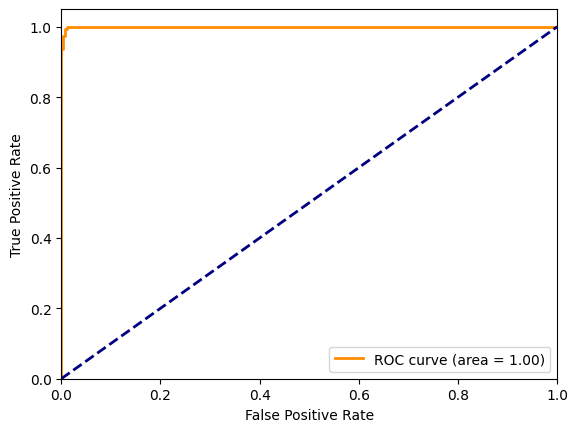

In [38]:
model = torchvision.models.resnet18(weights = None)
model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
model = torch.nn.DataParallel(model)
try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

test(model, test_dataloader, save_path, "RGB")

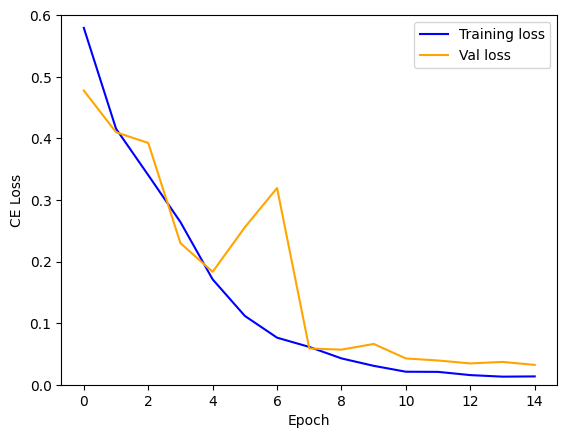

In [50]:
# Plot convergence
plt.plot(train_errors, label='Training loss', color='blue')
plt.plot(val_errors, label='Val loss',color='orange')
plt.ylabel("CE Loss")
plt.xlabel("Epoch")
plt.ylim([0,0.6])
plt.legend()